In fine-tuning transfer learning the pre-trained model weights from another model are unfrozen and tweaked during to better suit your own data.

For feature extraction transfer learning, you may only train the top 1-3 layers of a pre-trained model with your own data, in fine-tuning transfer learning, you might train 1-3+ layers of a pre-trained model (where the '+' indicates that many or all of the layers could be trained).

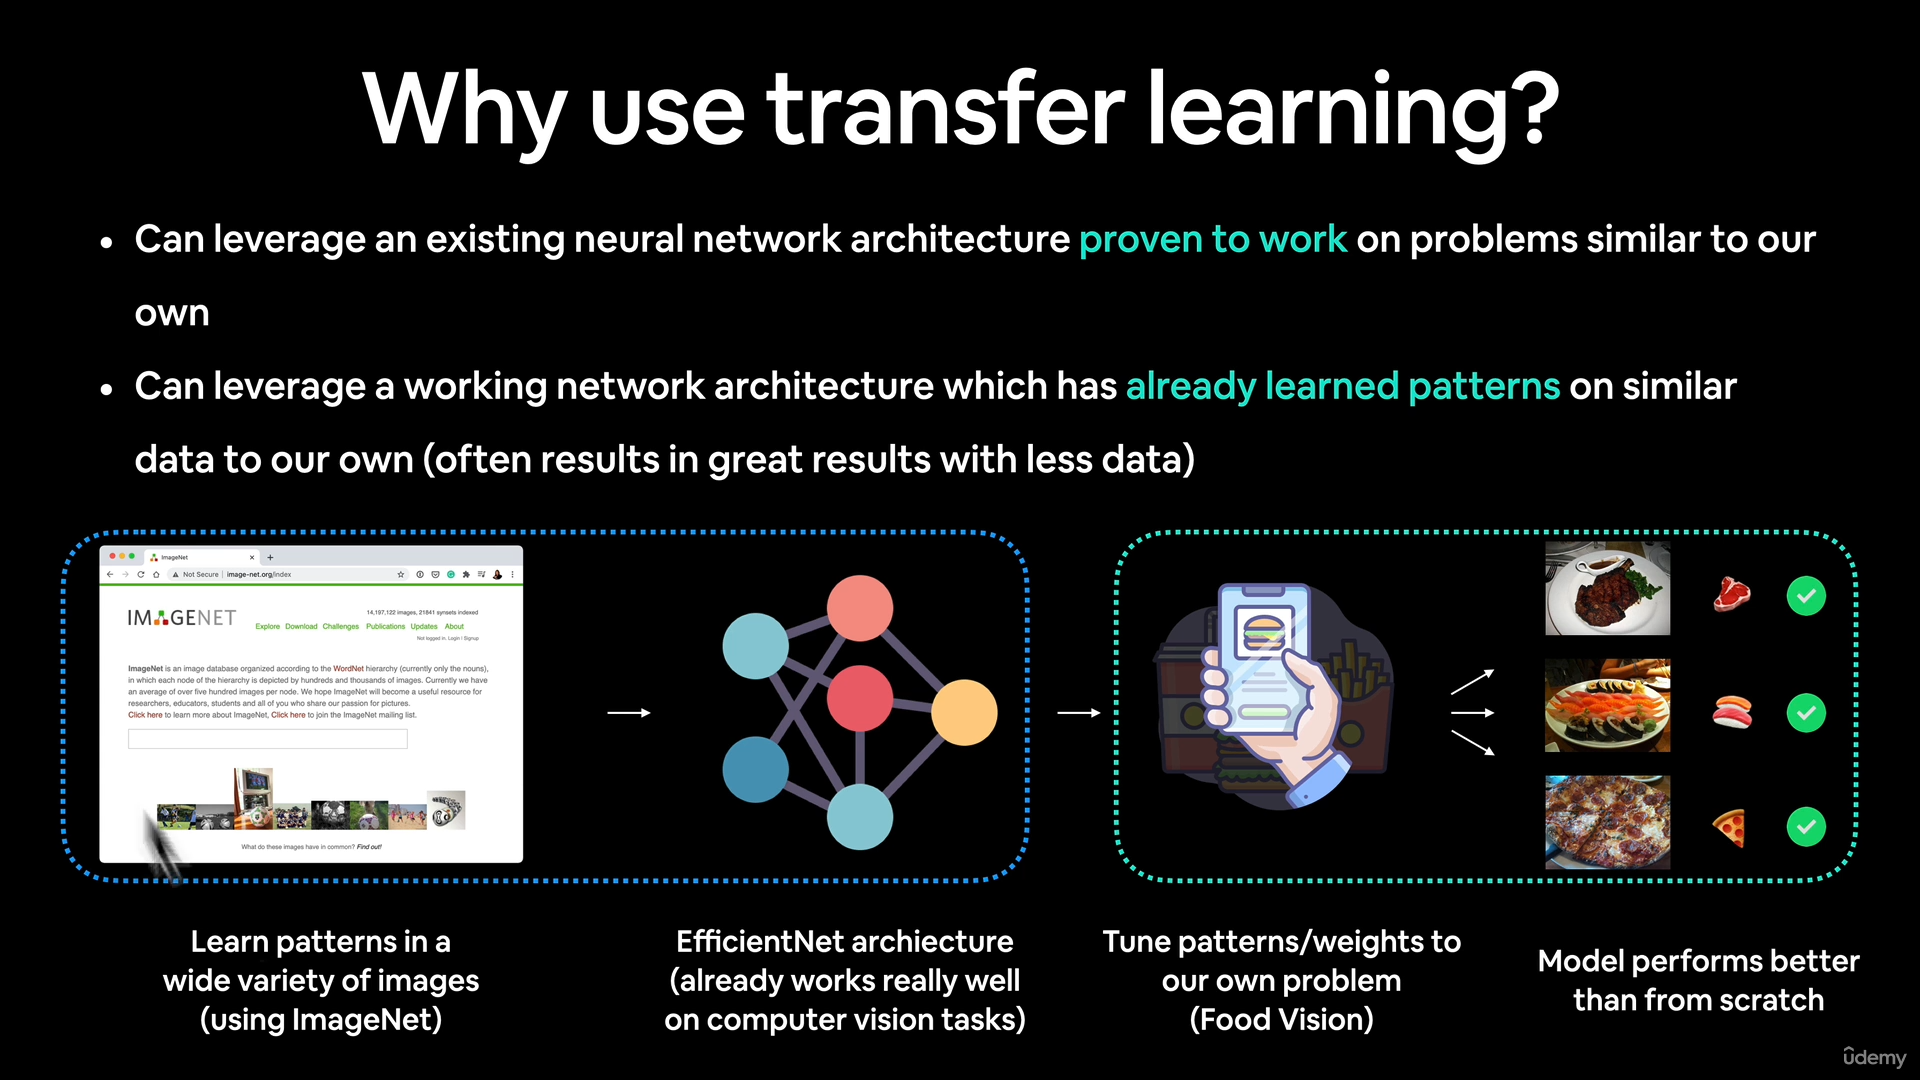


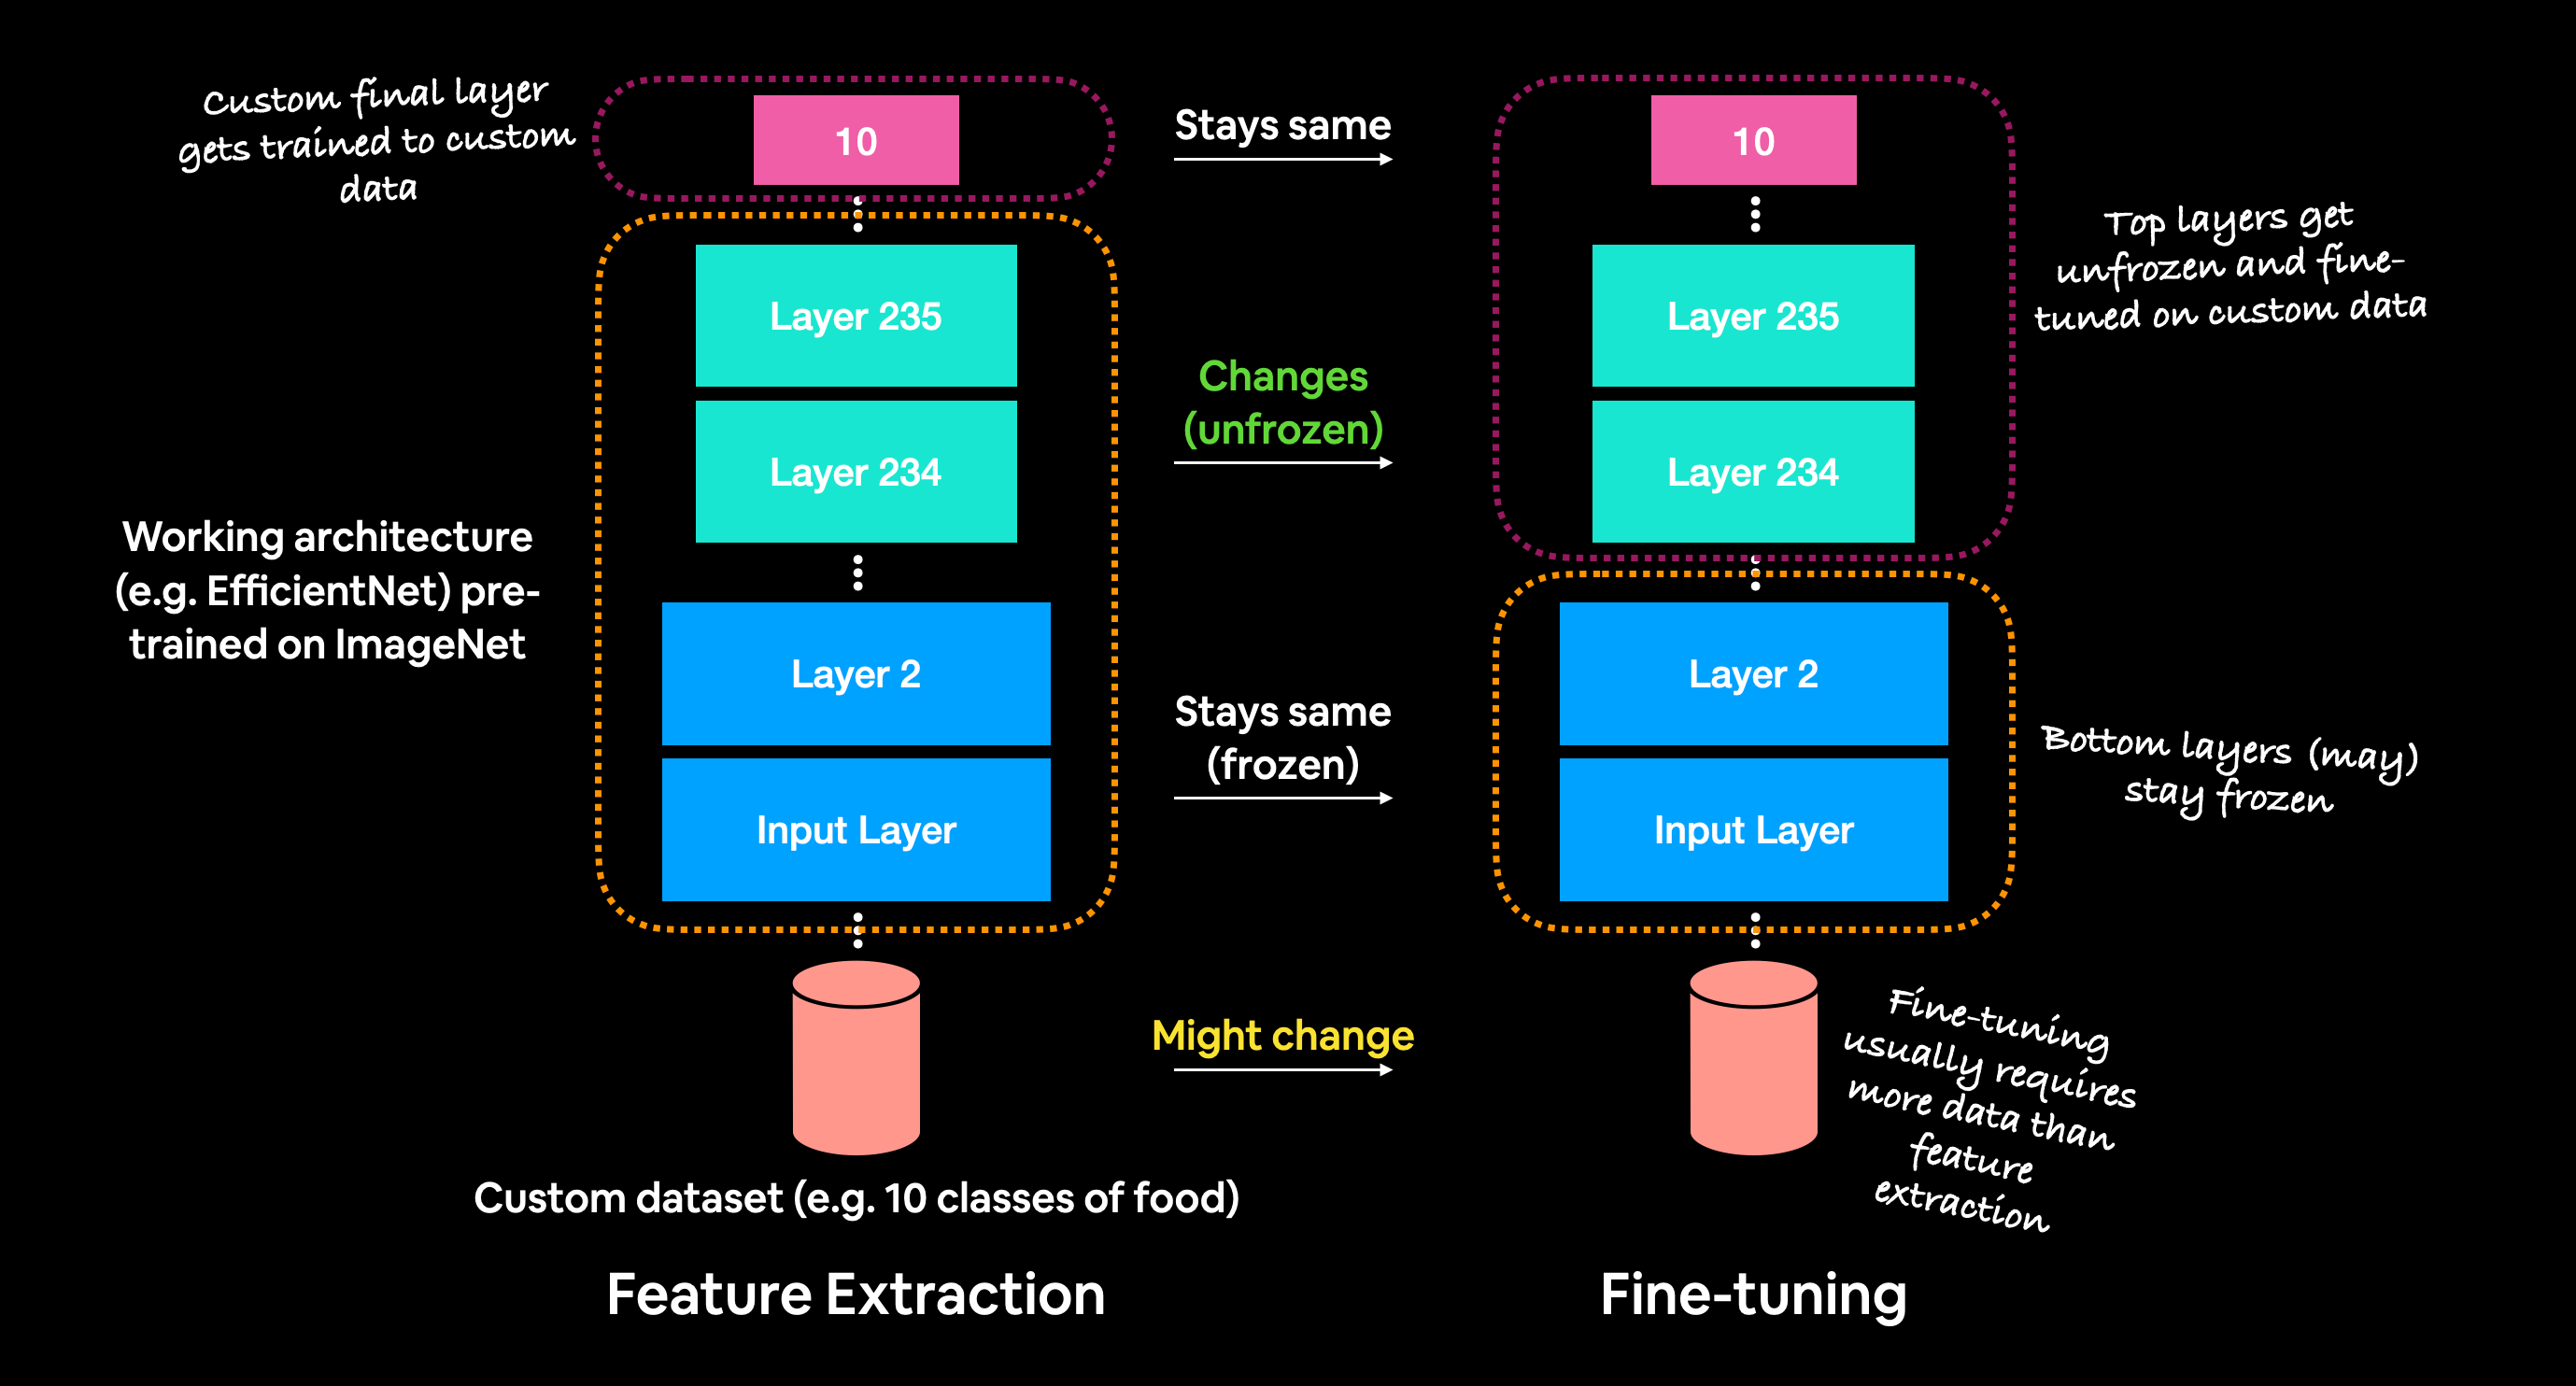

Feature extraction transfer learning vs. fine-tuning transfer learning. The main difference between the two is that in fine-tuning, more layers of the pre-trained model get unfrozen and tuned on custom data. This fine-tuning usually takes more data than feature extraction to be effective.

# Tensorflow Transfer Learning Part 2: Fine-tuning



In [ ]:
# Check if GPU is used
!nvidia-smi

Wed Nov 30 05:14:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Create helper functions

Get the helper fn from github

In [ ]:
!wget https://raw.githubusercontent.com/SNNJM/Tensorflow_Deep_Learning/main/extras/helper_function.py

--2022-11-30 05:15:06--  https://raw.githubusercontent.com/SNNJM/Tensorflow_Deep_Learning/main/extras/helper_function.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10308 (10K) [text/plain]
Saving to: ‘helper_function.py’

helper_function.py  100%[===================>]  10.07K  --.-KB/s    in 0s      

2022-11-30 05:15:06 (99.4 MB/s) - ‘helper_function.py’ saved [10308/10308]



In [ ]:
# Import the helper fn
from helper_function import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

🔑 **Note:** If we're running this notebook in Google Colab, when it times out, Colab will delete `helper_function.py`, so we'll have to re-download it to get access again.

## Let's get some data

This time we're going to see how we can use the pretrained  models within `tf.keras.applications` and apply them to our own problem (recognizing images of food).

link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [ ]:
# Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2022-11-30 05:15:17--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 142.251.12.128, 172.253.118.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  23.3MB/s    in 7.9s    

2022-11-30 05:15:26 (20.5 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/gr

In [ ]:
# Create training and test dir paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32 #Default=32

#Turn data into tensors of numbers
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", #multiclass="categorical"=categorical_crossentropy   binary="binary"=binary_crossentropy
                                                                            batch_size=BATCH_SIZE)

# Note: Test data does not change, only train data change
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical", #multiclass="categorical"=categorical_crossentropy   binary="binary"=binary_crossentropy
                                                                batch_size=BATCH_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

This time the data type is Batch dataset

(None, 224, 224, 3) -- the batch shoud be 32 instead None

This is just leaving a dimension in our tensor for four diff batches

so each batch will be 32 images of 224 x 224 pixels with 3 colour channels (RGB)

The labels are on hot encoded

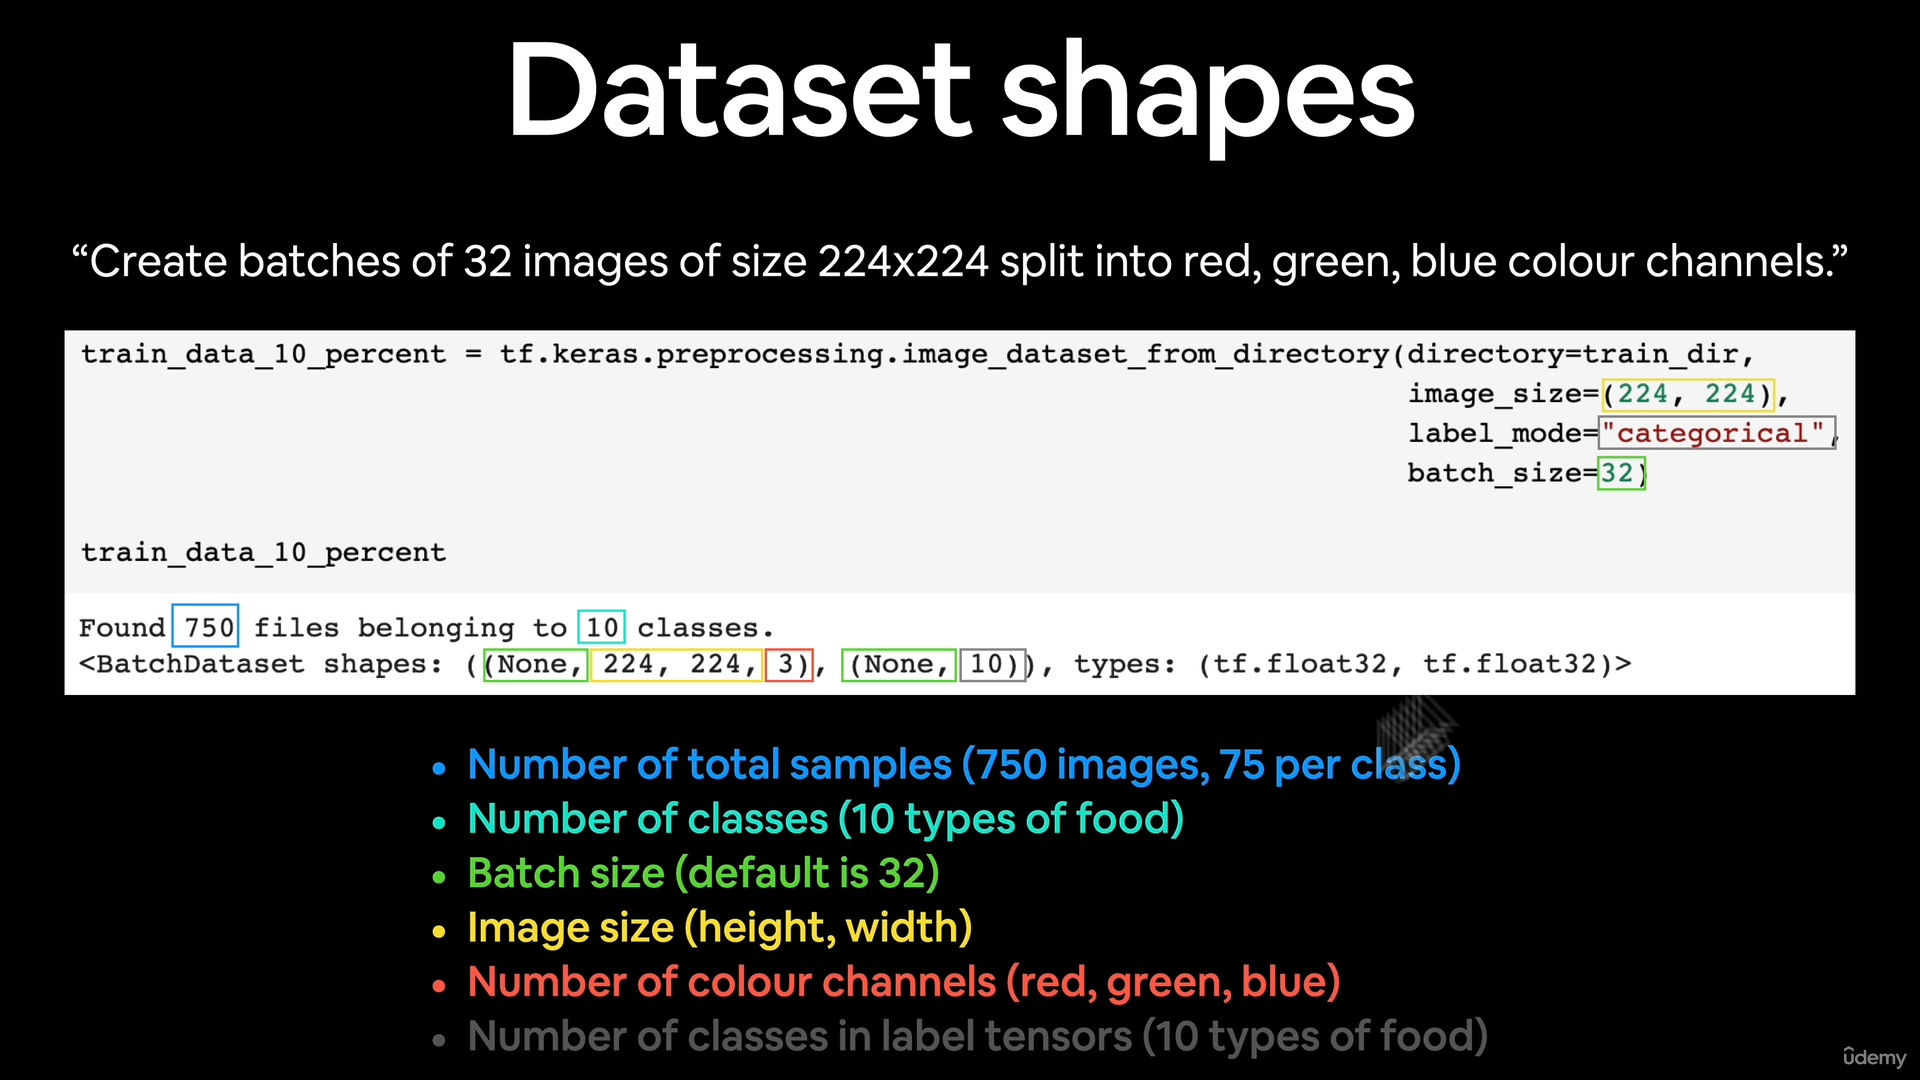

In [ ]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[199.94388  252.11734  246.94388 ]
   [192.63776  245.63776  239.63776 ]
   [196.15306  247.64795  243.14285 ]
   ...
   [243.41322  253.       243.1275  ]
   [242.95407  252.95407  242.61732 ]
   [242.35715  253.       240.07143 ]]

  [[195.22958  250.30103  245.44388 ]
   [194.68878  249.76021  244.90306 ]
   [192.63266  247.70409  244.7347  ]
   ...
   [241.65819  252.65819  244.91328 ]
   [242.92857  253.92857  246.20409 ]
   [243.33167  254.33167  246.14285 ]]

  [[179.72958  238.08673  235.87245 ]
   [176.07654  234.43369  232.21939 ]
   [192.67346  250.86224  249.24489 ]
   ...
   [238.26022  250.04593  247.18884 ]
   [239.69899  251.48471  248.91325 ]
   [240.64285  252.42857  248.      ]]

  ...

  [[ 73.474464  60.54594   57.11735 ]
   [ 69.928604  57.000076  53.571487]
   [ 71.57141   58.214294  55.      ]
   ...
   [132.54083   89.449005  72.80621 ]
   [135.31633   93.31632   79.31632 ]
   [134.93866   92.93867   79.367256]]

  [[ 66.311134  60.36221   54.4336

Dataset is now ready

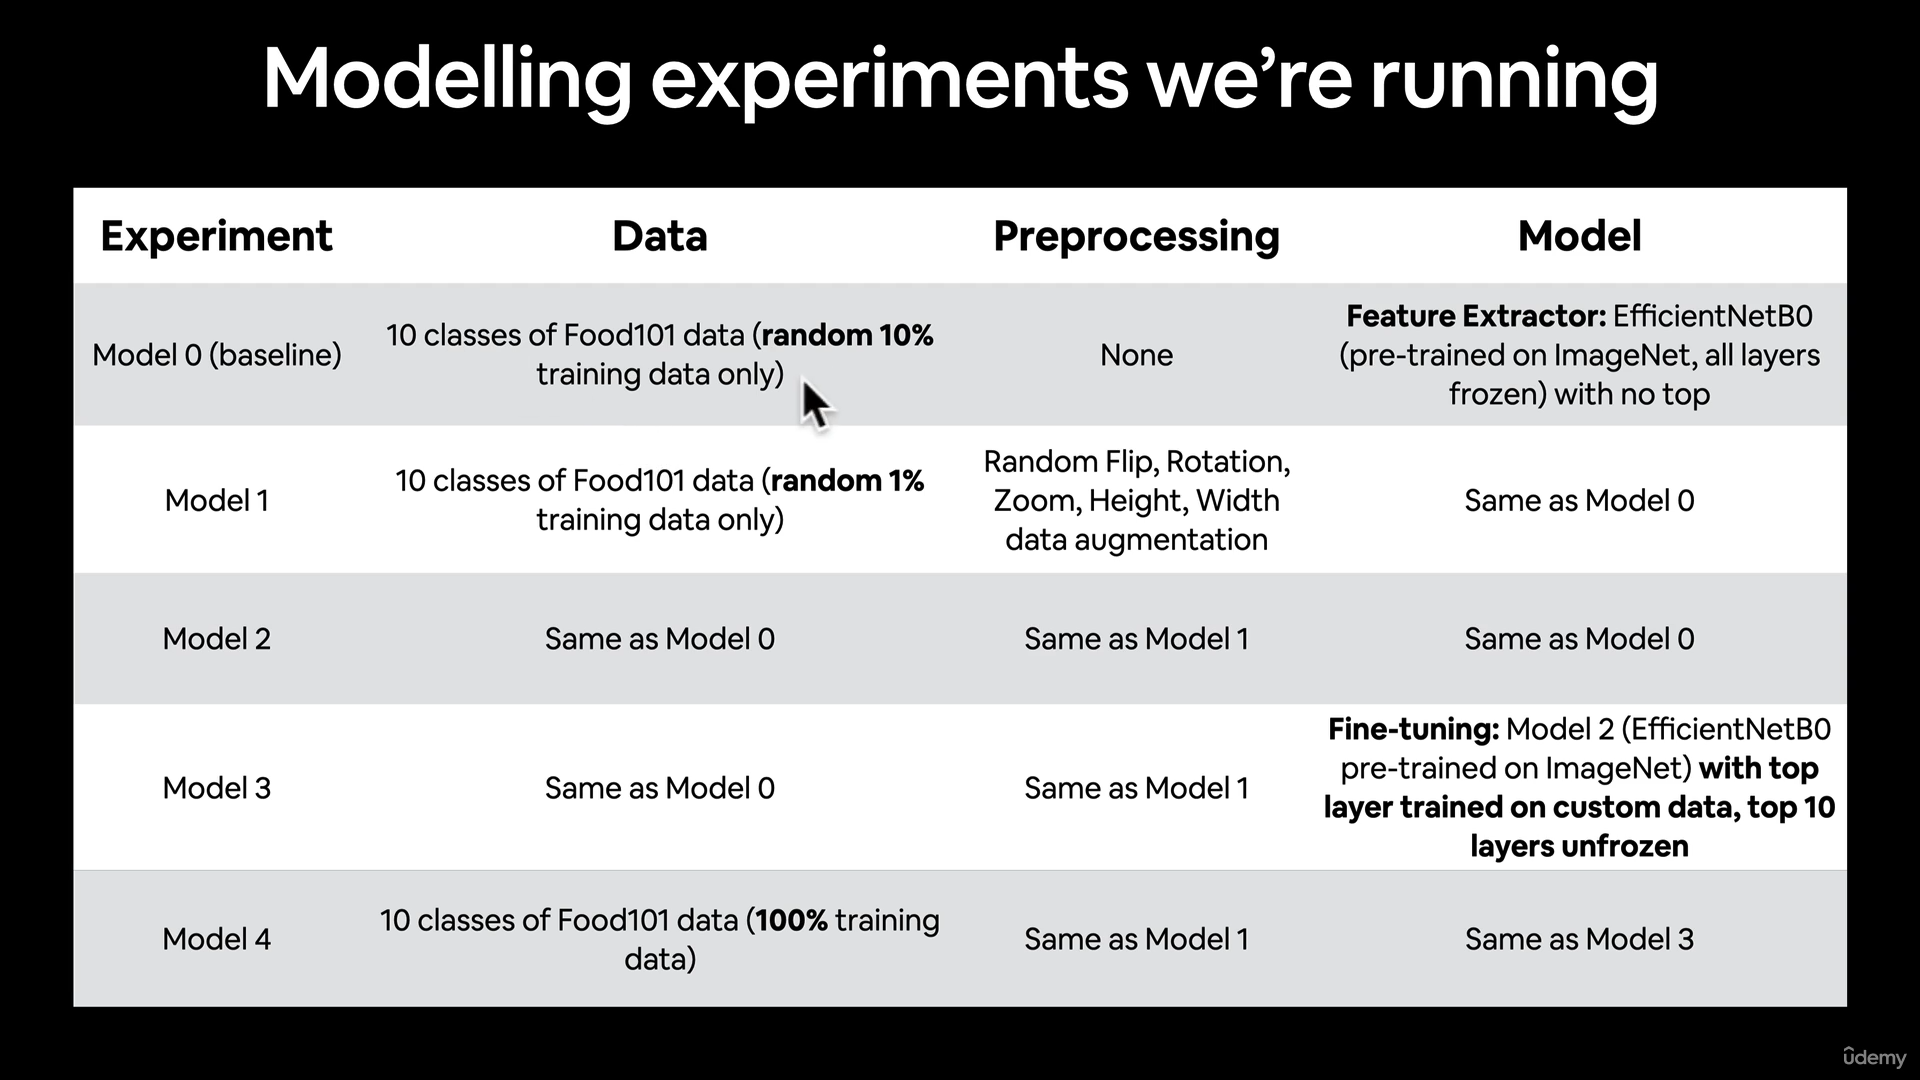

Previously we are using the Keras Sequential to create a model. Now we are using another API called functional

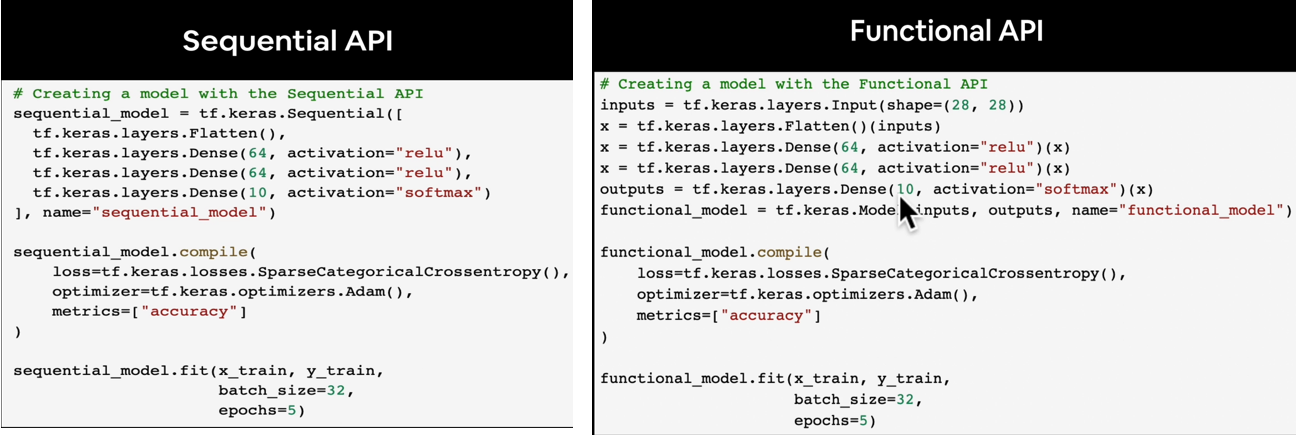

* Similarities: compiling, fitting, evaluating

* Differences: model construction (the Functional API is more flexible and able to produce more sophisticated models)

## Model 0: Building a transfer learning feature extraction model using the Keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order

But the functional API gives us more flexibility with our models

ResNet50V2: https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet_v2/ResNet50V2

In [ ]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False) # we want to include our own top layer

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using a model like ResNet50V2, we'll need to normalize inputs. No need for EfficientNet
# If model is not learning or having issues, enable this line
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggreate the most important information, reduce num of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)


# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


# 10 Fit the model & save its history
history_0 = model_0.fit(train_data_10_percent,
                        epochs=15,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)), # validate only on 25% of data, so its quicker since test data is larger
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                               experiment_name="10_percent_feature_extraction")])


16705208/16705208 [==============================] - 2s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20221130-051615
Epoch 1/15
24/24 [==============================] - 20s 263ms/step - loss: 1.8405 - accuracy: 0.4453 - val_loss: 1.3096 - val_accuracy: 0.7122
Epoch 2/15
24/24 [==============================] - 7s 299ms/step - loss: 1.0856 - accuracy: 0.7373 - val_loss: 0.9011 - val_accuracy: 0.8092
Epoch 3/15
24/24 [==============================] - 4s 159ms/step - loss: 0.7874 - accuracy: 0.8213 - val_loss: 0.7162 - val_accuracy: 0.8421
Epoch 4/15
24/24 [==============================] - 4s 154ms/step - loss: 0.6395 - accuracy: 0.8667 - val_loss: 0.6400 - val_accuracy: 0.8470
Epoch 5/15
24/24 [==============================] - 5s 185ms/step - loss: 0.5450 - accuracy: 0.8907 - val_loss: 0.5718 - val_accuracy: 0.8684
Epoch 6/15
2

In [ ]:
# Evaluate on full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 7s 77ms/step - loss: 0.4006 - accuracy: 0.8812


[0.4006066620349884, 0.8812000155448914]

In [ ]:
# Check layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 tf.math.truediv
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [ ]:
# Summary of base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [ ]:
# summary of our whole model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


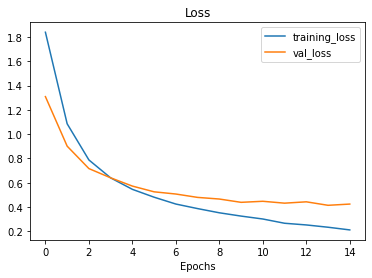

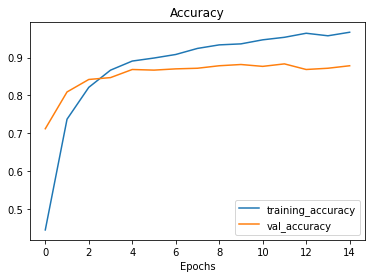

In [ ]:
# Check out our model's training curves
plot_loss_curves(history_0)

### Get a feature vector from a trained model

Let's demo the Global Average Pooling 2D layer

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280)

But then when it passes through GlobalAveragePoolig2D, it turns into (None, 1280)

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [ ]:
import tensorflow as tf

# Define input shape
input_shape = (1, 4, 4, 3)

# Create random tensor to represent image that we pass through model
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}")

# Pass the random tensor through a global average pooling 2D layer
gobal_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {gobal_average_pooled_tensor}\n")

# Check the shape of the diff tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {gobal_average_pooled_tensor.shape}")


Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]
2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


Tensor is converted to a vector (1D)

2D global average pool condensed the random input tensors into a smaller vector

This vector is input to our final (output) dense layer

In [ ]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2]) 

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

Feature vector is a learned representation of the input data (a compressed form of the input data based on how the model see's it)







### Running a series of transfer learning experiments

Experiments with 1% of training data 

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation

2. `model_2` - use feature extraction transfer learning with 10% of the training with data augmentation

3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation

4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation

* refer to the experiment slide (photo) above

🔑 **NOTE:** throughout all experiments the same test dataset will be used to evaluate our model... this ensures consistency across evaluation metrics.

### Getting and preprocessing data for `model_1`

In [ ]:
# Download and unzip data -- preprocessed from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")

--2022-11-30 05:18:48--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 142.250.4.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  23.3MB/s    in 6.6s    

2022-11-30 05:18:56 (19.3 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
# Create train and test dir
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test" # we are using the same test data across our exp

In [ ]:
# Check how many images are we working with
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There a

In [ ]:
# Setup data loaders
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE) #default =32


test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)                                                  

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.




### Adding data augmentation right into the model

To add data augmentation right into our models, we can use the layers inside:

*` tf.keras.layers.experimental.preprocessing`

We can see the benefits of doing this within the Tensorflow Data augmentation documentation:https://www.tensorflow.org/tutorials/images/data_augmentation#use_keras_preprocessing_layers


Off the top of our heads, after reading the dics, the benefits of using data augmentation inside the model are:
* Preprocessing of images (augmenting them) happens on the GPU (much faster) rather than the CPU.
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere.


The Concept:
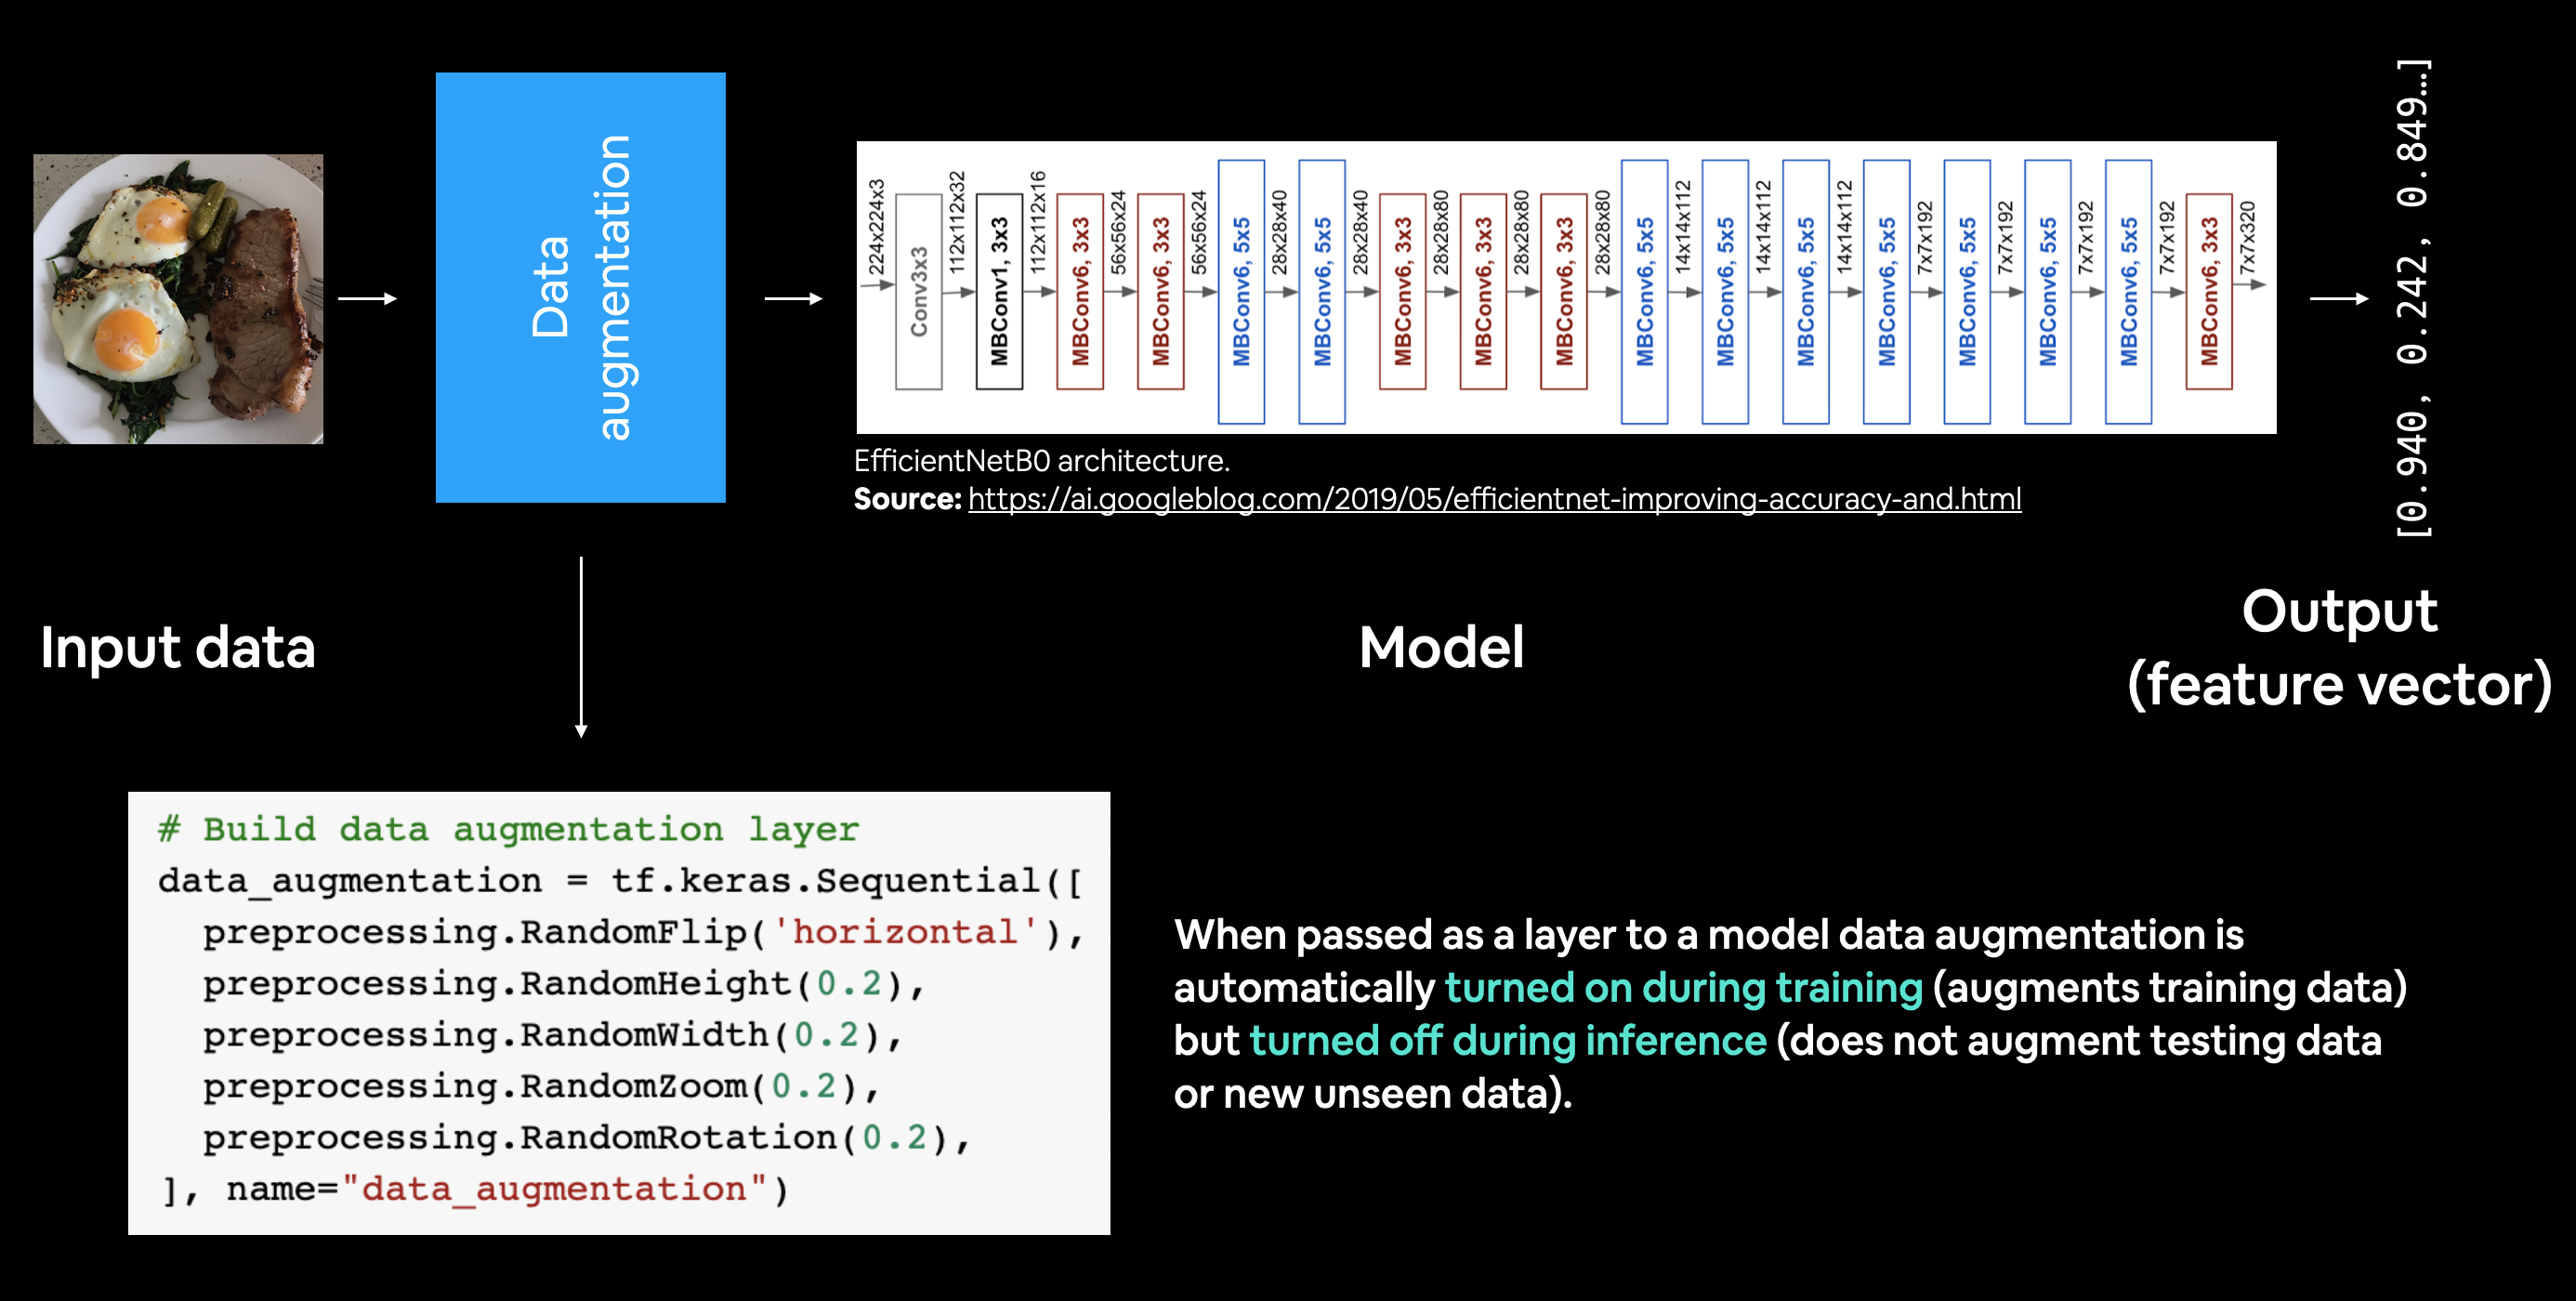


In [ ]:
print(tf.__version__)

2.9.2


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")


### Visualize our data augmentation layer

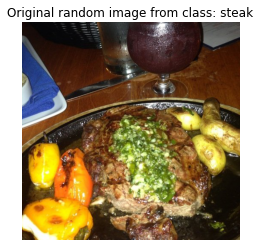

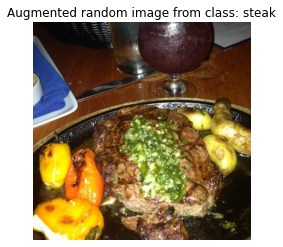

In [ ]:
# View random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names) # choose a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path

# Read and plot in random image
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes
#print(img)

# Plot augmented random image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
# Enable this if above is not working
#augmented_img = data_augmentation(img, training=True)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [ ]:
# Setup input shape and base model, freezing te base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool putput features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooing_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Create a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)), # make training faster
                                # Track model training logs
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="1_percent_data_aug")])


Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20221130-052003
Epoch 1/5
3/3 [==============================] - 12s 2s/step - loss: 2.4167 - accuracy: 0.0714 - val_loss: 2.2235 - val_accuracy: 0.1711
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.1504 - accuracy: 0.2286 - val_loss: 2.0988 - val_accuracy: 0.2730
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 1.9671 - accuracy: 0.3286 - val_loss: 1.9640 - val_accuracy: 0.3882
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.8035 - accuracy: 0.5000 - val_loss: 1.8646 - val_accuracy: 0.4737
Epoch 5/5
3/3 [==============================] - 3s 2s/step - loss: 1.6135 - accuracy: 0.6571 - val_loss: 1.7543 - val_accuracy: 0.5526


Transfer learning is able to equal the performance of the model that we created from scratch! (40%)

In [ ]:
IMG_SIZE

(224, 224)

In [ ]:
IMG_SIZE + (3,)

(224, 224, 3)

In [ ]:
# Check model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooing_layer  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [ ]:
# Evaluate on full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 6s 73ms/step - loss: 1.7879 - accuracy: 0.5120


[1.7878859043121338, 0.5120000243186951]

the accuracy on full data (test_data)--47% is slightly worst that the 1% data (48%)

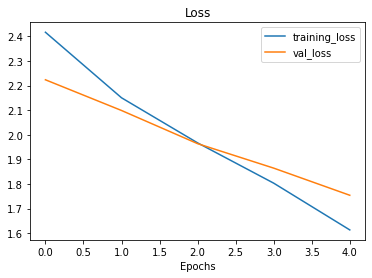

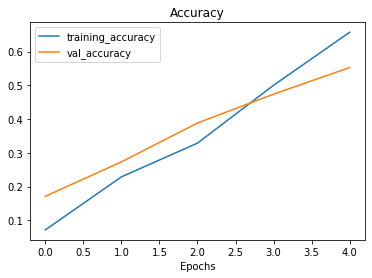

In [ ]:
# Loss curve 
plot_loss_curves(history_1_percent)

Both heading to the same direction

towards the end, they went quite far apart, meybe coz its running out of data to test on

## Model 2: Feature extraction transfer learning model with 10% of data and data augmentation

In [ ]:
# Uncomment to Get 10% of data
#!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
#unzip_data("10_food_classes_10_percent.zip")

train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir= "10_food_classes_10_percent/test"


In [ ]:
# Create data loaders

# Set data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Check how many images are in our dir
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/gr

In [ ]:
# Create model 2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2),
    # preprocessing.Rescaling(1./255) # Enable this if model != EfficeintNet-- this model ady have rescaling
    ], name="data_augmentation")

# Setup input shape to model
input_shape = (224, 224, 3)

# Create a frozen base model (also called backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create inputs and outputs (including layers in between)
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs) # augment training data
x = base_model(x, training=False) 
# pass augmented images to base model but keep it in inference mode, this also insures batchnorm layers dont get updated
# our base model is going to output a multidimensional tensor and we want to compress that multidimensional into feature vector
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])





In [ ]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_2D (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [ ]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


### Creating a ModelCheckpoint

Callbacks are a tool which can add helpful functionality to our model during training, evaluation or inference

Some popular callbacks:

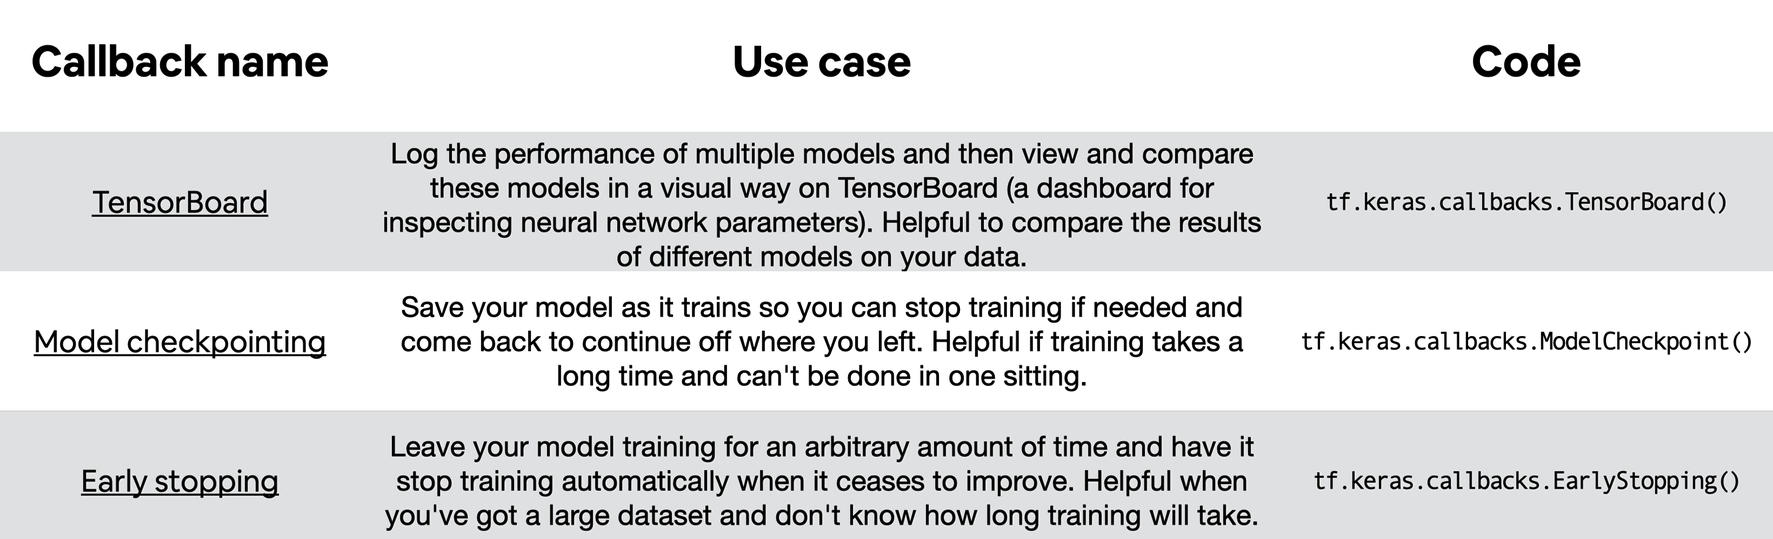

The ModelCheckpoint callback immediately saves our model (the full model or just the weights) during training. This is useful so we can come and start where we left off

In [ ]:
# Set checkpoint path
#default is in tmp folder
checkpoint_path = "ten_precent_model_checkpoints_weights/checkpoint.ckpt"

# Create ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch", #save every epoch
                                                         verbose=1)

### Fit model 2 passing in the ModelCheckpoint callbacks

In [ ]:
# Fit the model saving checkpoint every epoch
initial_epochs = 5 #initially fit our feature extraction model for maybe 5 epochs then fine tune model another 5 epochs
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)), # make training faster
                                          callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="10_percent_data_aug"),
                                                     checkpoint_callback])                                          



Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20221130-052215
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9493 - accuracy: 0.3573
Epoch 1: saving model to ten_precent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 19s 518ms/step - loss: 1.9493 - accuracy: 0.3573 - val_loss: 1.4428 - val_accuracy: 0.6645
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3005 - accuracy: 0.7160
Epoch 2: saving model to ten_precent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 11s 431ms/step - loss: 1.3005 - accuracy: 0.7160 - val_loss: 0.9761 - val_accuracy: 0.7862
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9635 - accuracy: 0.7960
Epoch 3: saving model to ten_precent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 10s 367ms/step - loss: 0.9635 - accuracy: 0.7960 - val_loss: 0.7746 - val_accuracy: 0.8289
E

In [ ]:
# model_0 result
model_0.evaluate(test_data)

79/79 [==============================] - 12s 123ms/step - loss: 0.4006 - accuracy: 0.8812


[0.4006066918373108, 0.8812000155448914]

In [ ]:
# Check model_2 results on all test data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 6s 74ms/step - loss: 0.6124 - accuracy: 0.8404


[0.6124039888381958, 0.840399980545044]

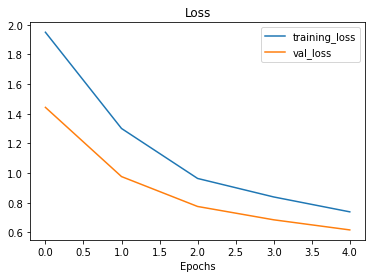

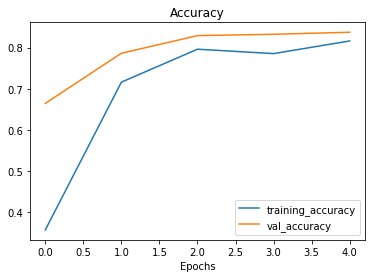

In [ ]:
# Plot loss curve
plot_loss_curves(history_10_percent_data_aug)

Model 2 seem to be heading to the right direction

Maybe if it's trained with more epochs, we can push this to the limit

### Load in checkpointed weights

Loading in checkpointed weights returns a model to a specific checkpoint

In [ ]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [ ]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 6s 74ms/step - loss: 0.6124 - accuracy: 0.8404


In [ ]:
# If result from prev evaluated model_2 match the loaded weights, everything has worked!
results_10_percent_data_aug == loaded_weights_model_results

False

HAHA... we did something wrong...

The computer stores numbers at different precision.
The output is not the exact number coz of how computer store that numbers (decimal points matters!)



In [ ]:
# Check to see if loade model results are very close to our previous non-loaded model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results)) #compare 2 diff numpy array



array([ True,  True])

In [ ]:
# Check the differences
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[5.96046448e-08 0.00000000e+00]


## Model 3: Fine-tuning an existing model on 10% of the data

High level example of fine tuning on EfficientNet model.

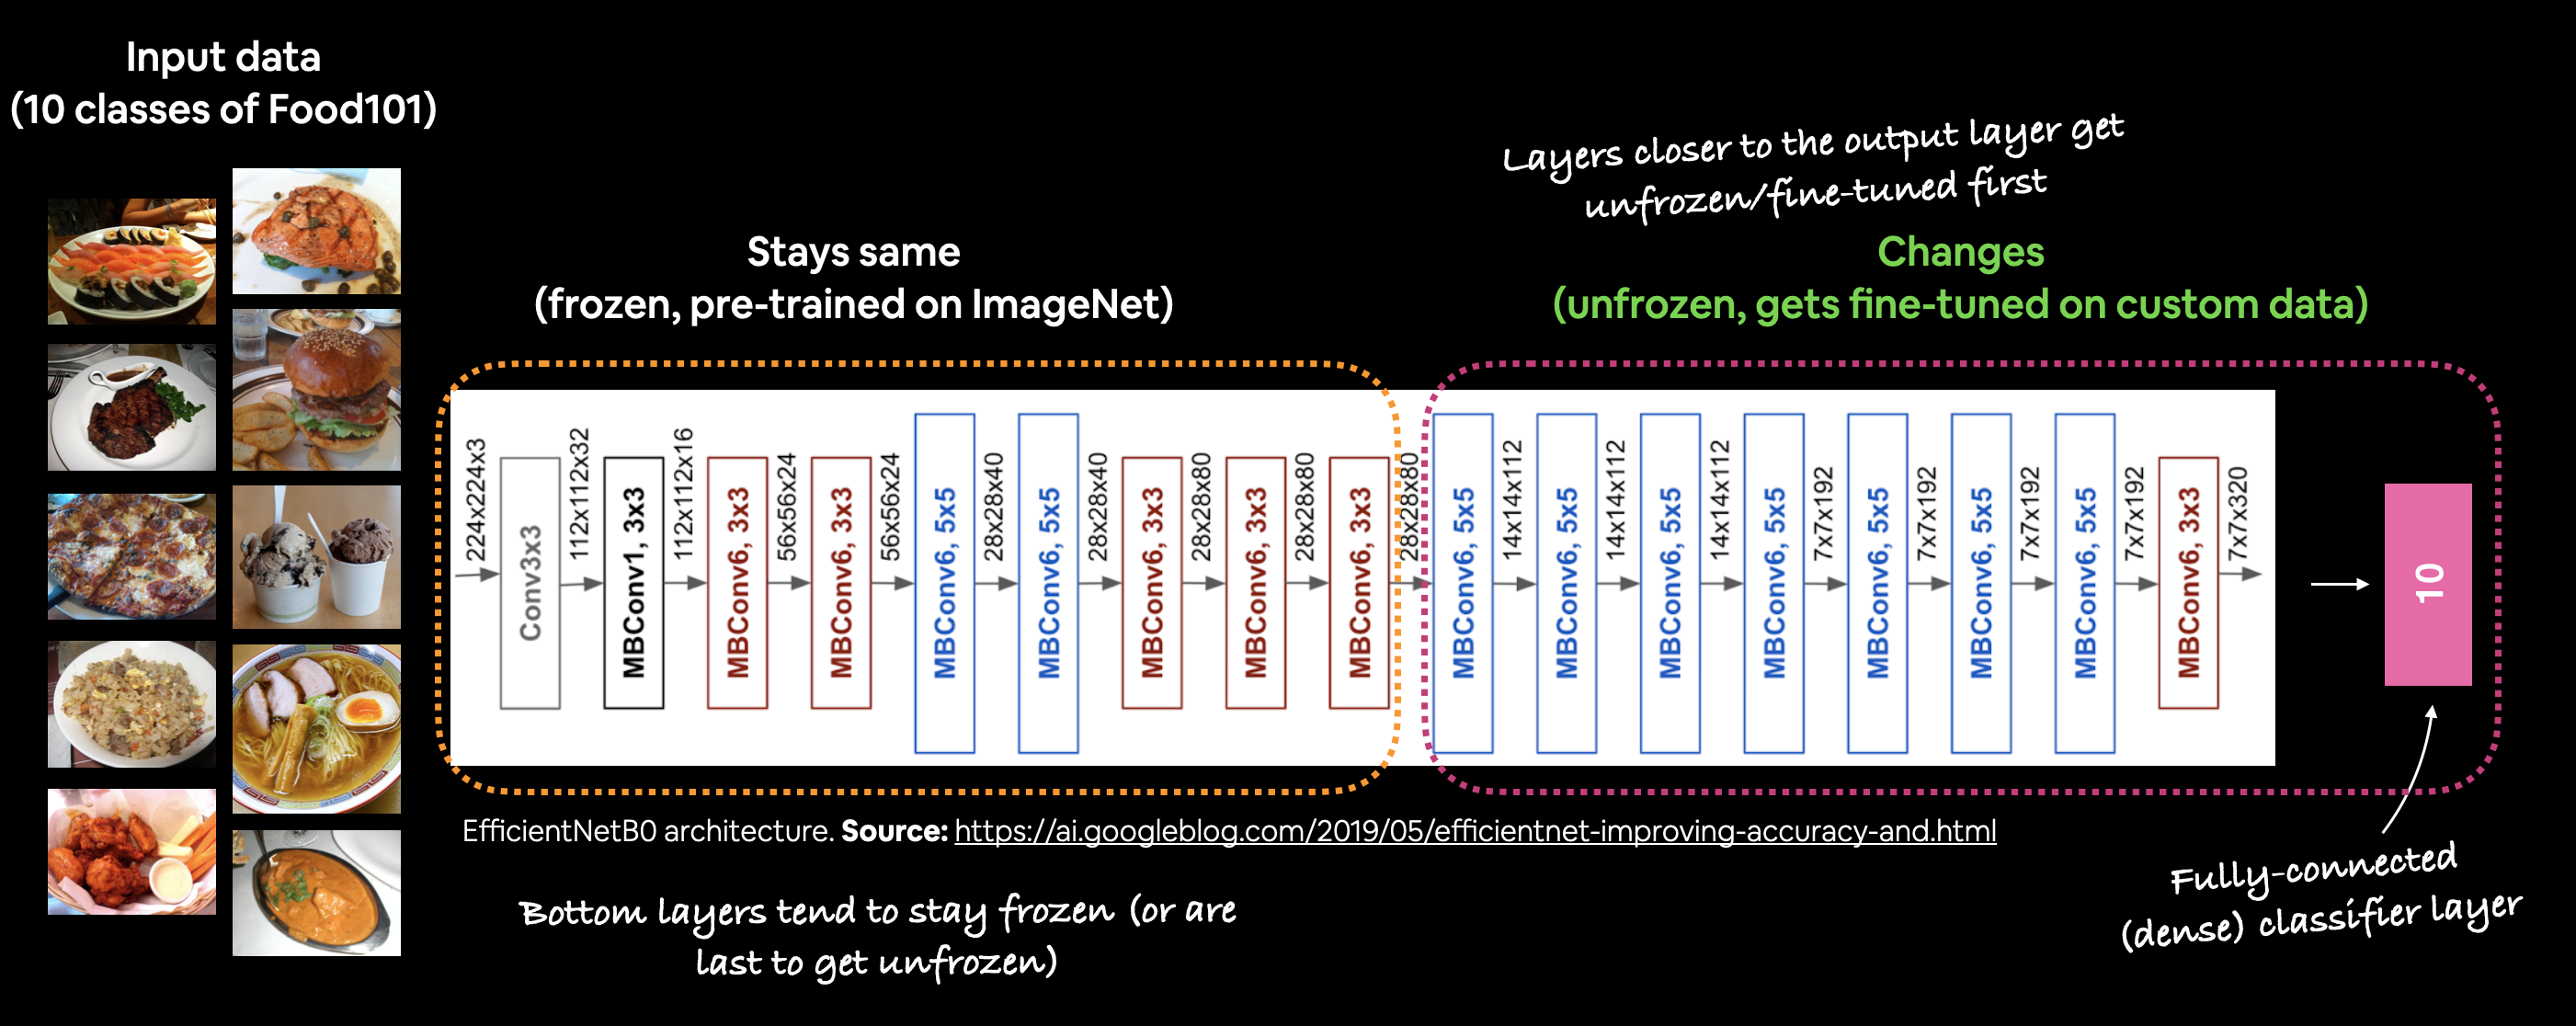

Bottom layers (layers closer to the input data) stay frozen where as top layers (layers closer to the output data) are updated during training.

🔑 **Note:** Fine-tuning usually works best *after* training a feature extraction model for a few epochs with large amounts of custom data.


model_3 is the fine-tuned version of model_2

In [ ]:
# Layers in loaded model
model_2.layers

In [ ]:
# Are these trainable?
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fdf90007bd0> True
<keras.engine.sequential.Sequential object at 0x7fdf8f210650> True
<keras.engine.functional.Functional object at 0x7fdf8f9d4090> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7fdf8ff13790> True
<keras.layers.core.dense.Dense object at 0x7fdf8fa59250> True


In [ ]:
# What layers are in our base_model(EfficientNetB0) and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 tf.math.truediv_2 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

All layers in EfficientNetB0 are not trainable since this is a pretrained model.

They are freezed so that they could sustain whatever they had learned.

However, in this step, we need to unfreeze some of those layers (last 10)
..Make them trainable

In [ ]:
# How many trainable variable are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [ ]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = true
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:  #every layer except last 10
  layer.trainable =  False

# Recompile (need to recompile after every changes)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                metrics=["accuracy"])


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Generally, the LR  dictates how much a model should update its internal patterns or internal weights, epoch to epoch or sample to sample based on the lost fn as well as the optimizer.

Becoz these layers already learned some patterns on an existing data set, we don't want it to drastically change those patterns since that's going to result in **overfitting**

We need to lower the LR by 10x (not necessary by 10x as long as its lower.
0.001 ---> 0.0001

In [ ]:
# Check trainable layers
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 tf.math.truediv_2 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [ ]:
# Check for number of trainable variables
print(len(model_2.trainable_variables))

12


In [ ]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 but with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # start from previous last epoch
                                               validation_steps=int(0.25 * len(test_data)),
                                               callbacks=[create_tensorboard_callback("transfer_learning",
                                                                                      experiment_name="10_fine_tune_last_10")])

#start training from previous last epochs (from where it left off)

Saving TensorBoard log files to: transfer_learning/10_fine_tune_last_10/20221130-052554
Epoch 5/10
24/24 [==============================] - 20s 492ms/step - loss: 0.6075 - accuracy: 0.8213 - val_loss: 0.4581 - val_accuracy: 0.8602
Epoch 6/10
24/24 [==============================] - 9s 366ms/step - loss: 0.4889 - accuracy: 0.8467 - val_loss: 0.4638 - val_accuracy: 0.8454
Epoch 7/10
24/24 [==============================] - 9s 357ms/step - loss: 0.4370 - accuracy: 0.8680 - val_loss: 0.4177 - val_accuracy: 0.8635
Epoch 8/10
24/24 [==============================] - 9s 373ms/step - loss: 0.4205 - accuracy: 0.8600 - val_loss: 0.3901 - val_accuracy: 0.8684
Epoch 9/10
24/24 [==============================] - 8s 341ms/step - loss: 0.3530 - accuracy: 0.9013 - val_loss: 0.4079 - val_accuracy: 0.8602
Epoch 10/10
24/24 [==============================] - 10s 401ms/step - loss: 0.3037 - accuracy: 0.9280 - val_loss: 0.4162 - val_accuracy: 0.8553


In [ ]:
# Evaluate the fine-tuned model (model_3 = model_2 + 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 6s 75ms/step - loss: 0.4100 - accuracy: 0.8592


In [ ]:
# Before fine tuning
results_10_percent_data_aug

[0.6124039888381958, 0.840399980545044]

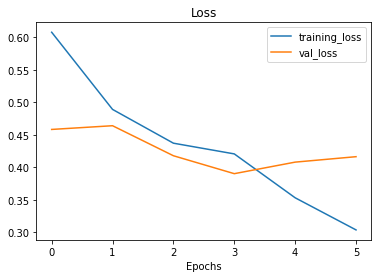

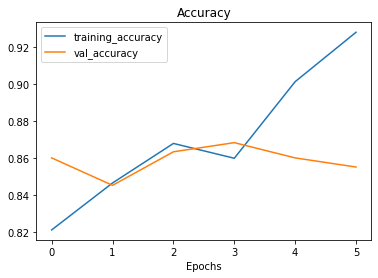

In [ ]:
# Check loss curve
plot_loss_curves(history_fine_10_percent_data_aug)

kinda staggery all over

The `plot_loss_curves` function works great with models which have only been fit once, however, we want something to compare one series of running `fit()` with another (e.g before and after fine tuning)

In [ ]:
# Create a fn 
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots 
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.35733333230018616, 0.7160000205039978, 0.7960000038146973, 0.7853333353996277, 0.8159999847412109, 0.8213333487510681, 0.846666693687439, 0.8679999709129333, 0.8600000143051147, 0.9013333320617676, 0.9279999732971191]


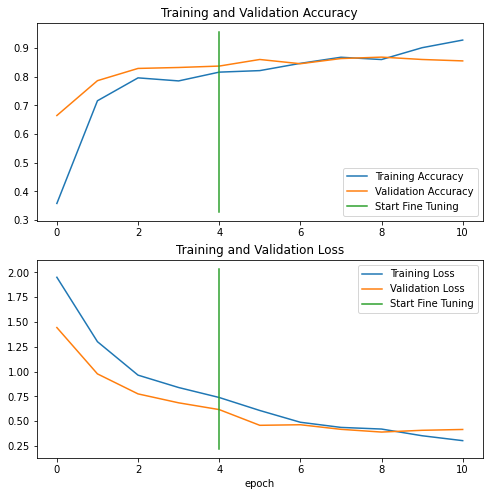

In [ ]:
compare_historys(original_history=history_10_percent_data_aug, 
                 new_history=history_fine_10_percent_data_aug, 
                 initial_epochs=5)

seems like the curves are heading in the right direction after fine-tuning. But remember, it should be noted that fine-tuning usually works best with larger amounts of data.

## Model 4: Fine-tuning an existing model on all of the data




In [ ]:
# Download and unzip 10 classes of Food101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2022-11-30 05:28:28--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 74.125.24.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  23.1MB/s    in 22s     

2022-11-30 05:28:50 (22.5 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
# Setup training and test dir
train_dir = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [ ]:
# How many images are we working now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

# Note: this is the same test dataset we've been using for the previous modelling experiments
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)



Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loaded in is the same as what we've been using for previous experiments (all exoeriments have used the same test dataset)

Let's verify this

In [ ]:
# Evaluate model_2 ( this is the fine-tuned on 10 percent of data version )
model_2.evaluate(test_data)

79/79 [==============================] - 6s 74ms/step - loss: 0.4100 - accuracy: 0.8592


[0.4100481867790222, 0.8592000007629395]

In [ ]:
results_fine_tune_10_percent

[0.410048246383667, 0.8592000007629395]

these two should results the same

--------------------------------------------------------------------------------

To train a fine-tuning model (model_4) we need to revert model_2 back to its feature extraction weights

In [ ]:
# Load weights from checkpoint, 
#that way we can fine-tune from the same stage the 10 percent data model was fine-tuned from
model_2.load_weights(checkpoint_path)

In [ ]:
# Let's evaluate model_2 now
# Theoretically this should be worst than the fine tuned version above
model_2.evaluate(test_data)

79/79 [==============================] - 6s 75ms/step - loss: 0.6124 - accuracy: 0.8404


[0.6124040484428406, 0.840399980545044]

In [ ]:
# Check to se if our model_2 has been reverted back to feature extraction results
results_10_percent_data_aug

[0.6124039888381958, 0.840399980545044]

These 2 results should be the same.
This means the model_2 has been reverted to the checkpoint (feature extraction weights)

In short, we've dine:

1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data with data augmentation (model_2) and we saved model's weights using `ModelCheckpoint` callback
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 ;ayers of the base model unfrozen (model_3)
3. Saved the results and training logs each time
4. Reloaded the model from step 1 to do the same steps as step 2 except this time we're going to use all of the data (model_4)

In [ ]:
# Check which layers are tunable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_2D True
4 output_layer True


In [ ]:
# Let's drill into our base_model (efficientnetb0) and see what layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

# Trainable layers should be as in model_3 --last 10 layers are trainable

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 tf.math.truediv_2 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [ ]:
# Re-Compile model
model_2.compile(loss="categorical_crossentropy",
                          optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                          metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Continue to train & fine-tune the model to our data (100% of training data)
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                  experiment_name="full_10_classes_fine_tune_last")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last/20221130-053811
Epoch 5/5
235/235 [==============================] - 60s 225ms/step - loss: 0.5330 - accuracy: 0.8269 - val_loss: 0.3298 - val_accuracy: 0.9013


In [ ]:
# Let's evaluate on all of the test data
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 6s 75ms/step - loss: 0.3197 - accuracy: 0.8936


[0.31974801421165466, 0.8935999870300293]

It looks like fine-tuning with all of the data has given our model a boost

5
6
[0.35733333230018616, 0.7160000205039978, 0.7960000038146973, 0.7853333353996277, 0.8159999847412109, 0.8269333243370056]


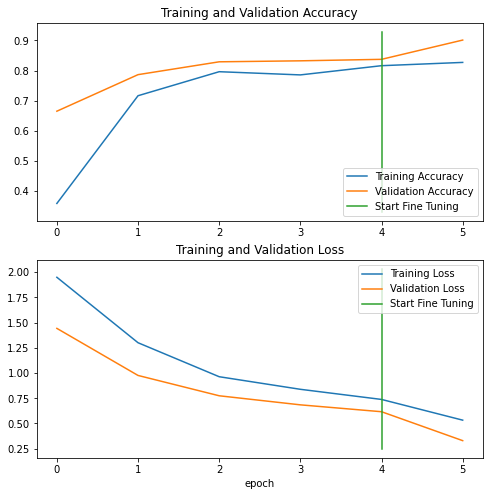

In [ ]:
# How did fine-tuning go with more data?
compare_historys(original_history=history_10_percent_data_aug,
                new_history=history_fine_10_classes_full)

## Viewing our experiment data on TensorBoard

🔑 **NOTE:** Anything uploade to TensorBoard.dev is going to be public. So, for any private data, DO NOT UPLOAD.

In [ ]:
# View tensorboard logs of transfer learning modelling experiments (should ~4 models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer learning experiments" \
  --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning" \
  --one_shot # exits the uploader when upload has finished


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=1PzyArz2d9zpYKobDvVX0RoEUzxteG&prompt=consent&access_type=o

Get rid train data in graph
Model_0 (w/o data augmentation) performs better than model_2


4/1AfgeXvtdv6VDTTcOlMKTrh2PjUVQ125Gq1GeaOninTcybAyxW791nBW0ahc

https://tensorboard.dev/experiment/EDfd5eXLR6KP0NwRoJxv2g/

## How to view and delete previous TensorBoard experiments

In [ ]:
!tensorboard dev list

https://tensorboard.dev/experiment/EDfd5eXLR6KP0NwRoJxv2g/
	Name                 Transfer learning experiments
	Description          A series of different transfer learning experiments with varying amounts of data and fine-tuning
	Id                   EDfd5eXLR6KP0NwRoJxv2g
	Created              2022-11-30 05:41:27 (1 minute ago)
	Updated              2022-11-30 05:41:38 (1 minute ago)
	Runs                 12
	Tags                 5
	Scalars              198
	Tensor bytes         0
	Binary object bytes  5259587
https://tensorboard.dev/experiment/uGK6yvKYSemi8hEAoKebgQ/
	Name                 EfficientNetB02 vs ResNet101V2
	Description          Comparing two diff TF Hub feature extraction model architectures using 10& of the training data 
	Id                   uGK6yvKYSemi8hEAoKebgQ
	Created              2022-11-18 12:59:09
	Updated              2022-11-18 12:59:16
	Runs                 8
	Tags                 5
	Scalars              270
	Tensor bytes         0
	Binary object bytes  15

In [ ]:
# Use ID to delete it
!tensorboard dev delete --experiment_id <id>